#### Import all necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os

#### Set the device to GPU if available, otherwise it defaults to CPU.

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Define transformation applied to images in dataset:

- Resize the images to 128x128 pixels (input of the neural network)
- Convert the images to PyTorch tensors.

In [ ]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

#### Loads the datasets from the specified directory, then apply the defined transformations. Define loader for further use. Print the number of classes and samples in each dataset.

In [ ]:

# Load Dataset
data_dir = './data/vegetables'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Number of classes in dataset: {len(train_dataset.classes)}")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of samples in val dataset: {len(val_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

Number of classes in dataset: 15
Number of samples in train dataset: 15000
Number of samples in val dataset: 3000
Number of samples in test dataset: 3000


#### Visualize distribution of samples per class in training dataset. 

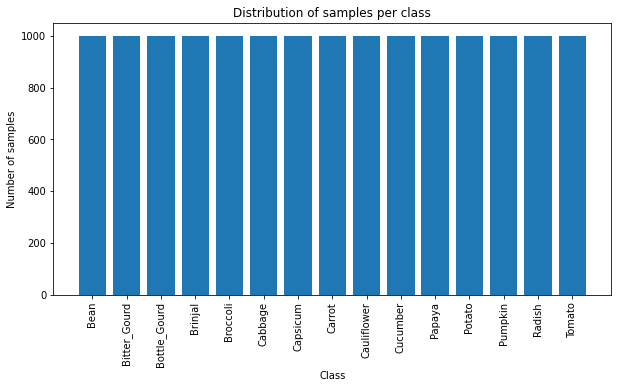

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(train_dataset.targets)
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
sorted_class_counts = [class_counts[i] for i in range(num_classes)]

plt.figure(figsize=(10, 5), facecolor='white')
plt.bar(range(num_classes), sorted_class_counts, tick_label=class_names)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Distribution of samples per class')
plt.xticks(rotation=90)
plt.show()

#### Define an architecture and forward function of a simple CNN model for image classification

In [ ]:
class VegetableClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VegetableClassifier, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 3 channels (RGB)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Assuming input image size is 128x128
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Feature Extraction
        x = F.relu(self.conv1(x))  # Convolution + Activation
        x = self.pool(x)           # Pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)           # Final pooled features

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128 * 16 * 16)  # Adjust size based on input dimensions

        # Classification Head
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)      # Output logits for classes
        return x

#### Define functions for model train and evaluation. They set necessary parameters, pass image through the model and compute the loss and accuracy of the model.

In [ ]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

#### Create a model and define loss function and optimizer for training.

In [ ]:

model = VegetableClassifier(num_classes).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Train model, print loss and accuracy after each epoch. Save the weights of the model which gave the best accuracy.

In [ ]:


num_epochs = 10
best_acc = 0.0

for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model_weights.pth')

print(f"Best Validation Accuracy: {best_acc:.4f}")

Epoch 1/10
Validation Loss: 0.7819, Validation Acc: 0.7453
Epoch 2/10
Validation Loss: 0.4769, Validation Acc: 0.8453
Epoch 3/10
Validation Loss: 0.2804, Validation Acc: 0.9147
Epoch 4/10
Validation Loss: 0.2236, Validation Acc: 0.9317
Epoch 5/10
Validation Loss: 0.1817, Validation Acc: 0.9483
Epoch 6/10
Validation Loss: 0.1987, Validation Acc: 0.9403
Epoch 7/10
Validation Loss: 0.1423, Validation Acc: 0.9597
Epoch 8/10
Validation Loss: 0.1257, Validation Acc: 0.9663
Epoch 9/10
Validation Loss: 0.1489, Validation Acc: 0.9663
Epoch 10/10
Validation Loss: 0.1499, Validation Acc: 0.9540
Best Validation Accuracy: 0.9663


#### Load the best weights and save the model with its full structure for further use.

In [24]:
model.load_state_dict(torch.load('best_model_weights.pth'))
whole_model = torch.jit.script(model)  # Export whole model
whole_model.save('whole_model.pt')

#### Evaluate the model on the test dataset, print the test loss and accuracy. Plot a confusion matrix and full statistics of the evaluation.

Test Loss: 0.1269, Test Accuracy: 0.9670


<Figure size 1872x1872 with 0 Axes>

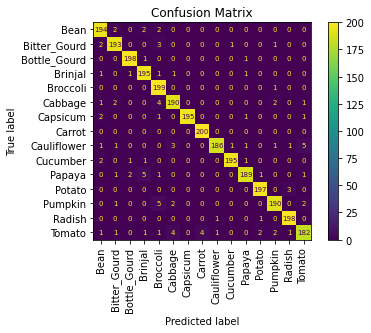

              precision    recall  f1-score   support

        Bean       0.95      0.97      0.96       200
Bitter_Gourd       0.96      0.96      0.96       200
Bottle_Gourd       0.98      0.99      0.99       200
     Brinjal       0.95      0.97      0.96       200
    Broccoli       0.92      0.99      0.95       200
     Cabbage       0.95      0.95      0.95       200
    Capsicum       1.00      0.97      0.99       200
      Carrot       0.98      1.00      0.99       200
 Cauliflower       0.99      0.93      0.96       200
    Cucumber       0.99      0.97      0.98       200
      Papaya       0.97      0.94      0.96       200
      Potato       0.98      0.98      0.98       200
     Pumpkin       0.96      0.95      0.96       200
      Radish       0.98      0.99      0.98       200
      Tomato       0.95      0.91      0.93       200

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97   

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def test_and_plot_stats(model, loader, device, class_names):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total

    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names,)
    plt.figure(figsize=(26, 26))  
    disp.plot(xticks_rotation='vertical')
    for texts in disp.text_.ravel():
        texts.set_fontsize(7)  
    plt.title('Confusion Matrix')
    plt.gcf().set_facecolor('white')
    plt.show()

    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)
        
class_names = train_dataset.classes
test_and_plot_stats(model, test_loader, device, class_names)

Visualize predictions by ploting grid of example images along with their predicted labels and ground truth.

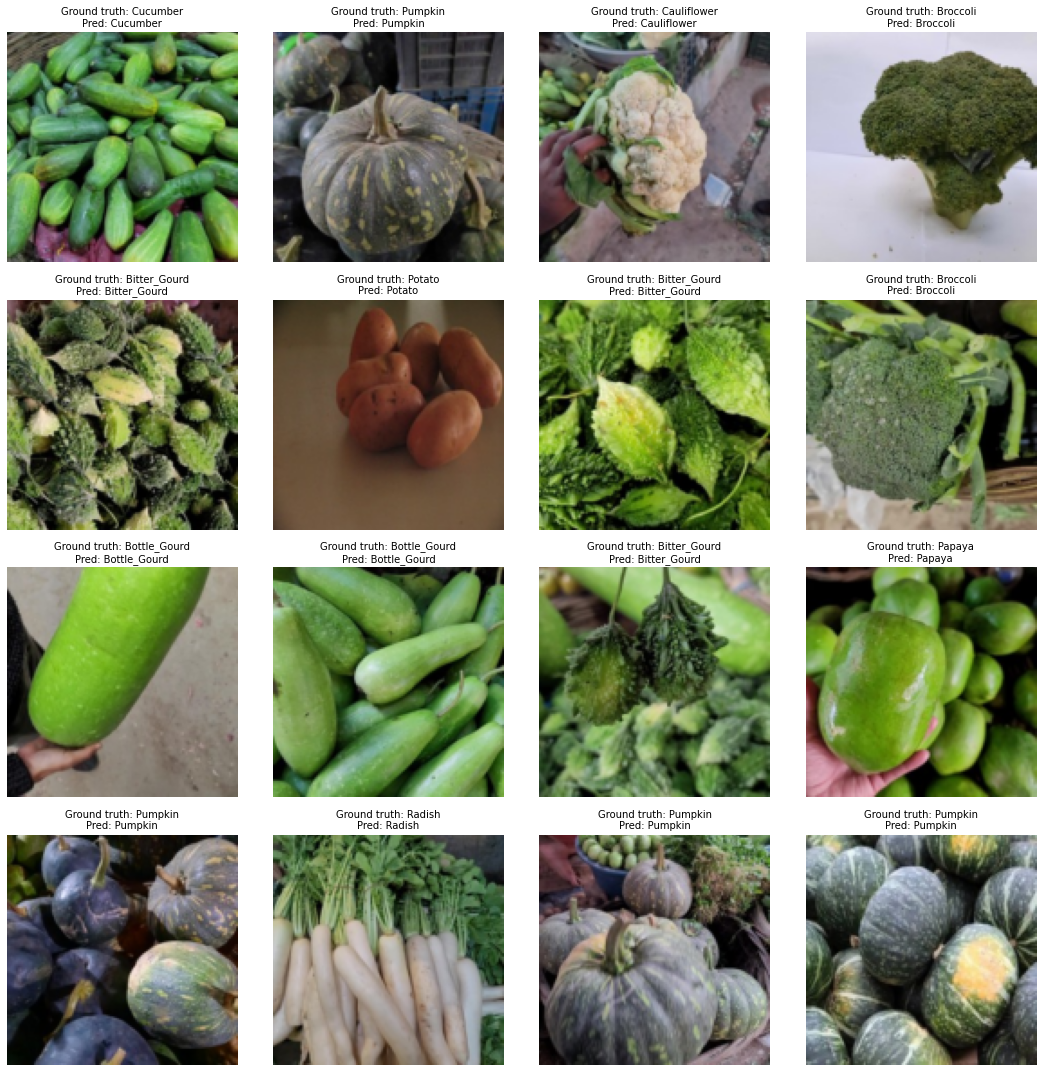

In [27]:
import matplotlib.pyplot as plt
import torch
import math


def plot_predictions(model, test_loader, class_names, device, num_images=8):
    model.eval()  # Set the model to evaluation mode
    images_shown = 0

    # Create a figure
    images_in_row = 4
    fig, ax = plt.subplots(math.ceil(num_images // images_in_row), images_in_row, figsize=(15, 15), facecolor='white')
    ax = ax.ravel()  # Flatten the axes for easier indexing

    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to the appropriate device
            images, labels = images.to(device), labels.to(device)

            # Get model predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Loop through the batch
            for i in range(images.size(0)):
                if images_shown >= num_images:  # Stop when we have enough images
                    break

                # Display the image
                image = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
                image = (image * 255).astype('uint8')  # Denormalize

                ax[images_shown].imshow(image)
                ax[images_shown].axis('off')

                # Add label information
                gt_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                ax[images_shown].set_title(f"Ground truth: {gt_label}\nPred: {pred_label}", fontsize=10)

                images_shown += 1

            if images_shown >= num_images:  # Break outer loop if needed
                break

    plt.tight_layout()
    plt.show()

plot_predictions(model, test_loader, train_dataset.classes, device, 16)